In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
from torch.jit import script, trace
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn import preprocessing

In [87]:
cwd = os.getcwd()

## Load EEG Data

In [88]:
#eeg_s = [
#    np.load("preprocessed_data_Sandra.npy"),
#    np.load("preprocessed_data_Ethan.npy"),
#]

eeg_s = [
    np.load("preprocessed_data_Sandra.npy")
]

In [89]:
def condense_preprocessed_data(eeg_pre):
    return np.array(
        [
            eeg_pre[i, :, j, :]
            for i in range(23)
            for j in range(eeg_pre.shape[2])
            if np.sum(eeg_pre[i, :, j, :]) != 0
        ]
    )


# Combine all sessions into one array
eeg_data = np.vstack([condense_preprocessed_data(session) for session in eeg_s])

print(eeg_data.shape)

(1676, 8, 750)


## Load VAD/Emotion Labels

In [90]:
emocsv = pd.read_csv("emotion-data/emotion_data.csv")
emocsv1 = emocsv.iloc[:, 5:]

In [91]:
new_cols = ["How feel", "Pos", "Energ", "Dom", "Content", "Amused", "Angry", "Sad", "Disgust", "Afraid", "Emo"]

In [92]:
emo_labels = pd.DataFrame()

for row in range(2):
    sel_row = emocsv1.iloc[row]
    for i in np.arange(0, emocsv1.shape[1], 11):
        obs = sel_row[i : i + 11].to_frame().T
        obs = obs.rename(columns={obs.columns[i]: new_cols[i] for i in range(11)})
        emo_labels = pd.concat([emo_labels, obs])
print(emo_labels)

                                            How feel Pos Energ Dom Content  \
0  disgusted, but the music made the video funny,...   2     3   7       1   
0                                          disgusted   2     3   7       1   
0                                          disgusted   1     5   7       1   
0                                            relaxed   6     5   8       3   
0                                         moved, sad   3     4   3       1   
0                                                sad   2     5   4       1   
0                                         angry, sad   1     6   3       1   
0                                            neutral   5     3   5       1   
0                                              angry   2     5   4       1   
0                                            annoyed   1     5   2       1   
0              a little bit annoyed, overall neutral   3     5   6       1   
0                                            neutral   5     5  

In [93]:
emo_labels["Pos2"] = emo_labels["Pos"]
emo_labels["Energ2"] = emo_labels["Energ"]
emo_labels["Dom2"] = emo_labels["Dom"]

#emo_labels["Pos2"] = (emo_labels["Pos"] > 4) + 0
#emo_labels["Energ2"] = (emo_labels["Energ"] > 4) + 0
#emo_labels["Dom2"] = (emo_labels["Dom"] > 4) + 0

In [94]:
valence = emo_labels['Pos2'].to_numpy()
arousal = emo_labels['Energ2'].to_numpy()
dominance = emo_labels['Dom2'].to_numpy()

In [95]:
y1, y2, y3 = [], [], []  # VAD labels given for each 3-second data chunk

for session_number, session in enumerate(eeg_s):
    for i in range(23):
        j = 0
        while j < session.shape[2] and np.sum(session[i, :, j, :]) != 0:
            idx = i + session_number * 23
            y1.append(valence[idx])
            y2.append(arousal[idx])
            y3.append(dominance[idx])
            j += 1

print(
    len(y1)
)  # this corresponds to the number of 3-second chunks across all data chunks. 1676 -> ~ 4 minutes per video on average, checks out

1676


In [96]:
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

## Create DataLoaders

In [97]:
indices = np.arange(len(eeg_data))
np.random.seed(1)
np.random.shuffle(indices)
indices

array([ 979, 1336,  881, ..., 1096,  235, 1061])

In [113]:
# Define the split ratios
ratios = [0.4, 0.4, 0.2]
train_ratio, valid_ratio, test_ratio = ratios

# Calculate split points
train_end = int(len(indices) * train_ratio)
valid_end = int(len(indices) * (train_ratio + valid_ratio))
test_end = int(len(indices) * (train_ratio + valid_ratio + test_ratio))

# Split the indices
train_indices, valid_indices, test_indices = (
    indices[:train_end],
    indices[train_end:valid_end],
    indices[valid_end:test_end],
)

# Print lengths of each split
print(
    f"Total: {len(indices)}, Train: {len(train_indices)}, Validation: {len(valid_indices)}, Test: {len(test_indices)}"
)

Total: 1676, Train: 670, Validation: 670, Test: 336


In [114]:
x_train = eeg_data[train_indices]
y_train_v = y1[train_indices]
y_train_a = y2[train_indices]
y_train_d = y3[train_indices]

x_valid = eeg_data[valid_indices]
y_valid_v = y1[valid_indices]
y_valid_a = y2[valid_indices]
y_valid_d = y3[valid_indices]

x_test = eeg_data[test_indices]
y_test_v = y1[test_indices]
y_test_a = y2[test_indices]
y_test_d = y3[test_indices]

In [115]:
import torch.utils
import torch.utils.data


train_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_v))
val_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_v))
test_dataset_v = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_v))

train_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_a))
val_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_a))
test_dataset_a = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_a))

train_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_d))
val_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_d))
test_dataset_d = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_d))

bsz = 50

train_loader_v = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_v = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_v = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

train_loader_a = torch.utils.data.DataLoader(train_subset_a, shuffle=True, batch_size=bsz)
val_loader_a = torch.utils.data.DataLoader(val_subset_a, shuffle=False, batch_size=bsz)
test_loader_a = torch.utils.data.DataLoader(test_dataset_a, shuffle=False, batch_size=bsz)

train_loader_d = torch.utils.data.DataLoader(train_subset_d, shuffle=True, batch_size=bsz)
val_loader_d = torch.utils.data.DataLoader(val_subset_d, shuffle=False, batch_size=bsz)
test_loader_d = torch.utils.data.DataLoader(test_dataset_d, shuffle=False, batch_size=bsz)

## Neural Network

In [101]:
samp_time = 750
n_channels = 8

In [102]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [103]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
v_net = CNN_LSTM()
print(v_net.forward(Variable(input_tensor)))
v_criterion = nn.CrossEntropyLoss() # add to device here
v_optimizer = optim.Adam(v_net.parameters(), lr=0.001, weight_decay=1e-7)

a_net = CNN_LSTM()
a_criterion = nn.CrossEntropyLoss() # add to device here
a_optimizer = optim.Adam(a_net.parameters(), lr=0.001, weight_decay=1e-7)

d_net = CNN_LSTM()
d_criterion = nn.CrossEntropyLoss() # add to device here
d_optimizer = optim.Adam(d_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.2117, 0.7883]], grad_fn=<SoftmaxBackward0>)


In [109]:
class CNN_LSTM_Reg(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Reg, self).__init__()
        self.conv1d = nn.Conv1d(
            in_channels=8, out_channels=40, kernel_size=20, stride=4
        )
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x

In [111]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
clr_net = CNN_LSTM_Reg()
print(clr_net.forward(Variable(input_tensor)))
clr_criterion = nn.MSELoss()  # add to device here
clr_optimizer = optim.Adam(d_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[-0.3604]], grad_fn=<AddmmBackward0>)


In [119]:
def train_net(net, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_hist = []
    val_hist = []

    for epoch_idx in tqdm(range(num_epochs)):
        net.train()
        #train_count = 0
        #train_correct_count = 0
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float()
            train_y = train_y.float()
            optimizer.zero_grad()
            op = net(train_x)
            loss = criterion(op, train_y)
            print(loss)
            loss.backward()
            optimizer.step()

            #with torch.no_grad():
            #    y_hat = logits.item()
            #    train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            #    train_count += train_x.size(0)

        #train_acc = train_correct_count / train_count
        #train_hist.append(train_acc)

        net.eval()
        #val_count = 0
        #val_correct_count = 0
        #with torch.no_grad():
        #    for idx, (val_x, val_y) in enumerate(val_loader):
        #        val_x = val_x.float()
        #        val_y = val_y.float()
        #        logits = net(val_x).detach()
        #        y_hat = torch.argmax(logits, dim=-1)
                #val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                #val_count += val_x.size(0)
        #val_acc = val_correct_count / val_count
        #val_hist.append(val_acc)
        #print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

    #plt.plot(train_hist)
    #plt.plot(val_hist)

In [105]:
def eval_net(net, test_loader):
    net.eval()
    test_count = 0
    test_correct_count = 0
    with torch.no_grad():
        for idx, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float()
            test_y = test_y.long()
            logits = net(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)
    test_acc = test_correct_count / test_count

    print('Test acc: {:.10f}'.format(test_acc))

In [120]:
train_net(clr_net, clr_optimizer, clr_criterion, train_loader_v, val_loader_v, 50)

  0%|          | 0/50 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(21.5759, grad_fn=<MseLossBackward0>)
tensor(19.8138, grad_fn=<MseLossBackward0>)
tensor(16.8043, grad_fn=<MseLossBackward0>)
tensor(19.4282, grad_fn=<MseLossBackward0>)
tensor(18.0162, grad_fn=<MseLossBackward0>)
tensor(19.6979, grad_fn=<MseLossBackward0>)
tensor(24.5317, grad_fn=<MseLossBackward0>)
tensor(21.5901, grad_fn=<MseLossBackward0>)
tensor(21.0435, grad_fn=<MseLossBackward0>)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

tensor(17.5578, grad_fn=<MseLossBackward0>)
tensor(17.0449, grad_fn=<MseLossBackward0>)
tensor(22.9844, grad_fn=<MseLossBackward0>)
tensor(20.1857, grad_fn=<MseLossBackward0>)
tensor(15.8293, grad_fn=<MseLossBackward0>)
tensor(17.3835, grad_fn=<MseLossBackward0>)
tensor(23.5820, grad_fn=<MseLossBackward0>)
tensor(15.6467, grad_fn=<MseLossBackward0>)
tensor(20.5272, grad_fn=<MseLossBackward0>)
tensor(28.1266, grad_fn=<MseLossBackward0>)


  4%|▍         | 2/50 [00:00<00:17,  2.81it/s]

tensor(18.4227, grad_fn=<MseLossBackward0>)
tensor(19.4892, grad_fn=<MseLossBackward0>)
tensor(20.2696, grad_fn=<MseLossBackward0>)
tensor(16.4315, grad_fn=<MseLossBackward0>)
tensor(19.5221, grad_fn=<MseLossBackward0>)
tensor(21.4520, grad_fn=<MseLossBackward0>)
tensor(18.4986, grad_fn=<MseLossBackward0>)
tensor(23.9404, grad_fn=<MseLossBackward0>)
tensor(16.5517, grad_fn=<MseLossBackward0>)
tensor(19.8929, grad_fn=<MseLossBackward0>)
tensor(23.2104, grad_fn=<MseLossBackward0>)
tensor(17.7256, grad_fn=<MseLossBackward0>)
tensor(17.5484, grad_fn=<MseLossBackward0>)
tensor(17.9267, grad_fn=<MseLossBackward0>)
tensor(20.2125, grad_fn=<MseLossBackward0>)
tensor(23.3709, grad_fn=<MseLossBackward0>)
tensor(23.3827, grad_fn=<MseLossBackward0>)
tensor(22.6497, grad_fn=<MseLossBackward0>)
tensor(17.9996, grad_fn=<MseLossBackward0>)
tensor(17.4013, grad_fn=<MseLossBackward0>)


  6%|▌         | 3/50 [00:01<00:15,  3.07it/s]

tensor(22.3349, grad_fn=<MseLossBackward0>)
tensor(20.1273, grad_fn=<MseLossBackward0>)
tensor(14.5548, grad_fn=<MseLossBackward0>)
tensor(20.4069, grad_fn=<MseLossBackward0>)
tensor(19.6402, grad_fn=<MseLossBackward0>)
tensor(20.8620, grad_fn=<MseLossBackward0>)
tensor(16.3975, grad_fn=<MseLossBackward0>)
tensor(16.7669, grad_fn=<MseLossBackward0>)
tensor(20.5155, grad_fn=<MseLossBackward0>)
tensor(17.9096, grad_fn=<MseLossBackward0>)
tensor(20.9310, grad_fn=<MseLossBackward0>)


  8%|▊         | 4/50 [00:01<00:14,  3.19it/s]

tensor(20.7060, grad_fn=<MseLossBackward0>)
tensor(18.1559, grad_fn=<MseLossBackward0>)
tensor(27.5875, grad_fn=<MseLossBackward0>)
tensor(21.5141, grad_fn=<MseLossBackward0>)
tensor(20.7681, grad_fn=<MseLossBackward0>)
tensor(25.6449, grad_fn=<MseLossBackward0>)
tensor(18.7029, grad_fn=<MseLossBackward0>)
tensor(18.4232, grad_fn=<MseLossBackward0>)
tensor(17.2208, grad_fn=<MseLossBackward0>)
tensor(21.3730, grad_fn=<MseLossBackward0>)


 10%|█         | 5/50 [00:01<00:13,  3.30it/s]

tensor(20.3913, grad_fn=<MseLossBackward0>)
tensor(22.9868, grad_fn=<MseLossBackward0>)
tensor(17.3293, grad_fn=<MseLossBackward0>)
tensor(18.9867, grad_fn=<MseLossBackward0>)
tensor(21.7398, grad_fn=<MseLossBackward0>)
tensor(18.2582, grad_fn=<MseLossBackward0>)
tensor(23.6970, grad_fn=<MseLossBackward0>)
tensor(21.2220, grad_fn=<MseLossBackward0>)
tensor(20.8443, grad_fn=<MseLossBackward0>)
tensor(20.5339, grad_fn=<MseLossBackward0>)
tensor(22.8905, grad_fn=<MseLossBackward0>)
tensor(22.8396, grad_fn=<MseLossBackward0>)
tensor(20.2864, grad_fn=<MseLossBackward0>)
tensor(17.7970, grad_fn=<MseLossBackward0>)
tensor(17.6022, grad_fn=<MseLossBackward0>)
tensor(18.1073, grad_fn=<MseLossBackward0>)


 12%|█▏        | 6/50 [00:02<00:15,  2.93it/s]

tensor(20.9200, grad_fn=<MseLossBackward0>)
tensor(18.6556, grad_fn=<MseLossBackward0>)
tensor(15.8046, grad_fn=<MseLossBackward0>)
tensor(21.9185, grad_fn=<MseLossBackward0>)
tensor(21.8143, grad_fn=<MseLossBackward0>)
tensor(24.6591, grad_fn=<MseLossBackward0>)
tensor(22.2214, grad_fn=<MseLossBackward0>)
tensor(18.0494, grad_fn=<MseLossBackward0>)
tensor(17.0932, grad_fn=<MseLossBackward0>)
tensor(20.6779, grad_fn=<MseLossBackward0>)
tensor(19.1494, grad_fn=<MseLossBackward0>)
tensor(17.0631, grad_fn=<MseLossBackward0>)
tensor(19.9598, grad_fn=<MseLossBackward0>)
tensor(19.3840, grad_fn=<MseLossBackward0>)
tensor(18.6034, grad_fn=<MseLossBackward0>)
tensor(19.2008, grad_fn=<MseLossBackward0>)
tensor(24.5056, grad_fn=<MseLossBackward0>)
tensor(21.5435, grad_fn=<MseLossBackward0>)


 14%|█▍        | 7/50 [00:02<00:14,  3.02it/s]

tensor(20.9505, grad_fn=<MseLossBackward0>)
tensor(22.4070, grad_fn=<MseLossBackward0>)
tensor(20.4881, grad_fn=<MseLossBackward0>)
tensor(23.2374, grad_fn=<MseLossBackward0>)
tensor(20.9294, grad_fn=<MseLossBackward0>)
tensor(21.4874, grad_fn=<MseLossBackward0>)
tensor(18.6901, grad_fn=<MseLossBackward0>)
tensor(18.1753, grad_fn=<MseLossBackward0>)
tensor(21.4686, grad_fn=<MseLossBackward0>)
tensor(16.2380, grad_fn=<MseLossBackward0>)


 16%|█▌        | 8/50 [00:02<00:14,  2.98it/s]

tensor(21.1558, grad_fn=<MseLossBackward0>)
tensor(17.9383, grad_fn=<MseLossBackward0>)
tensor(23.2296, grad_fn=<MseLossBackward0>)
tensor(18.7076, grad_fn=<MseLossBackward0>)
tensor(21.9538, grad_fn=<MseLossBackward0>)
tensor(23.3186, grad_fn=<MseLossBackward0>)
tensor(18.2861, grad_fn=<MseLossBackward0>)
tensor(20.4945, grad_fn=<MseLossBackward0>)
tensor(23.2006, grad_fn=<MseLossBackward0>)
tensor(14.7586, grad_fn=<MseLossBackward0>)
tensor(18.4333, grad_fn=<MseLossBackward0>)
tensor(22.9567, grad_fn=<MseLossBackward0>)
tensor(19.0956, grad_fn=<MseLossBackward0>)
tensor(24.8318, grad_fn=<MseLossBackward0>)
tensor(15.4348, grad_fn=<MseLossBackward0>)
tensor(24.7848, grad_fn=<MseLossBackward0>)
tensor(21.4339, grad_fn=<MseLossBackward0>)


 18%|█▊        | 9/50 [00:02<00:13,  3.03it/s]

tensor(20.4843, grad_fn=<MseLossBackward0>)
tensor(15.7841, grad_fn=<MseLossBackward0>)
tensor(17.5347, grad_fn=<MseLossBackward0>)
tensor(21.6283, grad_fn=<MseLossBackward0>)
tensor(17.1504, grad_fn=<MseLossBackward0>)
tensor(20.7311, grad_fn=<MseLossBackward0>)
tensor(18.3818, grad_fn=<MseLossBackward0>)
tensor(15.4497, grad_fn=<MseLossBackward0>)
tensor(20.8209, grad_fn=<MseLossBackward0>)
tensor(21.9242, grad_fn=<MseLossBackward0>)


 20%|██        | 10/50 [00:03<00:12,  3.08it/s]

tensor(21.8141, grad_fn=<MseLossBackward0>)
tensor(17.0203, grad_fn=<MseLossBackward0>)
tensor(18.3708, grad_fn=<MseLossBackward0>)
tensor(26.2693, grad_fn=<MseLossBackward0>)
tensor(19.7101, grad_fn=<MseLossBackward0>)
tensor(18.7626, grad_fn=<MseLossBackward0>)
tensor(19.7236, grad_fn=<MseLossBackward0>)
tensor(20.7243, grad_fn=<MseLossBackward0>)
tensor(26.2232, grad_fn=<MseLossBackward0>)
tensor(19.2760, grad_fn=<MseLossBackward0>)
tensor(16.9036, grad_fn=<MseLossBackward0>)
tensor(18.7123, grad_fn=<MseLossBackward0>)
tensor(22.4626, grad_fn=<MseLossBackward0>)
tensor(17.4398, grad_fn=<MseLossBackward0>)
tensor(23.0072, grad_fn=<MseLossBackward0>)
tensor(21.5030, grad_fn=<MseLossBackward0>)
tensor(21.5094, grad_fn=<MseLossBackward0>)
tensor(14.3691, grad_fn=<MseLossBackward0>)
tensor(22.5438, grad_fn=<MseLossBackward0>)
tensor(19.4157, grad_fn=<MseLossBackward0>)


 22%|██▏       | 11/50 [00:03<00:12,  3.14it/s]

tensor(25.0838, grad_fn=<MseLossBackward0>)
tensor(22.3788, grad_fn=<MseLossBackward0>)
tensor(20.1620, grad_fn=<MseLossBackward0>)
tensor(20.7299, grad_fn=<MseLossBackward0>)
tensor(19.3892, grad_fn=<MseLossBackward0>)
tensor(22.7528, grad_fn=<MseLossBackward0>)
tensor(20.9712, grad_fn=<MseLossBackward0>)
tensor(23.3254, grad_fn=<MseLossBackward0>)
tensor(18.2284, grad_fn=<MseLossBackward0>)
tensor(18.9201, grad_fn=<MseLossBackward0>)


 24%|██▍       | 12/50 [00:03<00:11,  3.18it/s]

tensor(15.9556, grad_fn=<MseLossBackward0>)
tensor(25.3593, grad_fn=<MseLossBackward0>)
tensor(21.9520, grad_fn=<MseLossBackward0>)
tensor(21.9282, grad_fn=<MseLossBackward0>)
tensor(19.4071, grad_fn=<MseLossBackward0>)
tensor(20.1316, grad_fn=<MseLossBackward0>)
tensor(17.1367, grad_fn=<MseLossBackward0>)
tensor(21.8254, grad_fn=<MseLossBackward0>)
tensor(20.9441, grad_fn=<MseLossBackward0>)
tensor(26.3786, grad_fn=<MseLossBackward0>)
tensor(16.9331, grad_fn=<MseLossBackward0>)
tensor(15.1180, grad_fn=<MseLossBackward0>)
tensor(20.4994, grad_fn=<MseLossBackward0>)
tensor(14.0493, grad_fn=<MseLossBackward0>)
tensor(21.7928, grad_fn=<MseLossBackward0>)
tensor(27.1621, grad_fn=<MseLossBackward0>)


 26%|██▌       | 13/50 [00:04<00:12,  3.02it/s]

tensor(18.4077, grad_fn=<MseLossBackward0>)
tensor(23.2167, grad_fn=<MseLossBackward0>)
tensor(19.5574, grad_fn=<MseLossBackward0>)
tensor(23.4331, grad_fn=<MseLossBackward0>)
tensor(17.5556, grad_fn=<MseLossBackward0>)
tensor(29.8795, grad_fn=<MseLossBackward0>)
tensor(23.5493, grad_fn=<MseLossBackward0>)
tensor(21.3180, grad_fn=<MseLossBackward0>)
tensor(14.6213, grad_fn=<MseLossBackward0>)
tensor(21.6929, grad_fn=<MseLossBackward0>)


 28%|██▊       | 14/50 [00:04<00:11,  3.09it/s]

tensor(19.9822, grad_fn=<MseLossBackward0>)
tensor(22.1914, grad_fn=<MseLossBackward0>)
tensor(20.6571, grad_fn=<MseLossBackward0>)
tensor(19.3475, grad_fn=<MseLossBackward0>)
tensor(13.9668, grad_fn=<MseLossBackward0>)
tensor(20.6000, grad_fn=<MseLossBackward0>)
tensor(16.1524, grad_fn=<MseLossBackward0>)
tensor(21.1747, grad_fn=<MseLossBackward0>)
tensor(13.9407, grad_fn=<MseLossBackward0>)
tensor(23.7581, grad_fn=<MseLossBackward0>)
tensor(16.0779, grad_fn=<MseLossBackward0>)
tensor(18.6830, grad_fn=<MseLossBackward0>)
tensor(18.7129, grad_fn=<MseLossBackward0>)
tensor(15.9945, grad_fn=<MseLossBackward0>)
tensor(18.5340, grad_fn=<MseLossBackward0>)
tensor(17.9463, grad_fn=<MseLossBackward0>)
tensor(20.5548, grad_fn=<MseLossBackward0>)
tensor(23.5758, grad_fn=<MseLossBackward0>)
tensor(24.2556, grad_fn=<MseLossBackward0>)
tensor(21.8225, grad_fn=<MseLossBackward0>)


 30%|███       | 15/50 [00:04<00:11,  3.16it/s]

tensor(21.4025, grad_fn=<MseLossBackward0>)
tensor(19.6838, grad_fn=<MseLossBackward0>)
tensor(25.4351, grad_fn=<MseLossBackward0>)
tensor(18.3245, grad_fn=<MseLossBackward0>)
tensor(20.2887, grad_fn=<MseLossBackward0>)
tensor(17.9967, grad_fn=<MseLossBackward0>)
tensor(16.2530, grad_fn=<MseLossBackward0>)
tensor(18.7718, grad_fn=<MseLossBackward0>)
tensor(22.3868, grad_fn=<MseLossBackward0>)
tensor(24.0252, grad_fn=<MseLossBackward0>)


 32%|███▏      | 16/50 [00:05<00:10,  3.24it/s]

tensor(19.2993, grad_fn=<MseLossBackward0>)
tensor(18.9099, grad_fn=<MseLossBackward0>)
tensor(23.2498, grad_fn=<MseLossBackward0>)
tensor(19.5546, grad_fn=<MseLossBackward0>)
tensor(18.9430, grad_fn=<MseLossBackward0>)
tensor(23.6212, grad_fn=<MseLossBackward0>)
tensor(19.3519, grad_fn=<MseLossBackward0>)
tensor(23.1380, grad_fn=<MseLossBackward0>)
tensor(21.4144, grad_fn=<MseLossBackward0>)
tensor(15.3741, grad_fn=<MseLossBackward0>)
tensor(17.7868, grad_fn=<MseLossBackward0>)
tensor(20.6672, grad_fn=<MseLossBackward0>)
tensor(19.6548, grad_fn=<MseLossBackward0>)
tensor(19.6638, grad_fn=<MseLossBackward0>)
tensor(21.7253, grad_fn=<MseLossBackward0>)
tensor(19.5971, grad_fn=<MseLossBackward0>)
tensor(17.0082, grad_fn=<MseLossBackward0>)


 34%|███▍      | 17/50 [00:05<00:10,  3.10it/s]

tensor(26.0037, grad_fn=<MseLossBackward0>)
tensor(15.5543, grad_fn=<MseLossBackward0>)
tensor(22.9100, grad_fn=<MseLossBackward0>)
tensor(26.0960, grad_fn=<MseLossBackward0>)
tensor(20.5362, grad_fn=<MseLossBackward0>)
tensor(18.8729, grad_fn=<MseLossBackward0>)
tensor(24.8261, grad_fn=<MseLossBackward0>)
tensor(20.3895, grad_fn=<MseLossBackward0>)
tensor(17.5297, grad_fn=<MseLossBackward0>)
tensor(21.9508, grad_fn=<MseLossBackward0>)


 36%|███▌      | 18/50 [00:05<00:10,  3.14it/s]

tensor(19.4797, grad_fn=<MseLossBackward0>)
tensor(18.2186, grad_fn=<MseLossBackward0>)
tensor(22.6781, grad_fn=<MseLossBackward0>)
tensor(18.5536, grad_fn=<MseLossBackward0>)
tensor(18.9870, grad_fn=<MseLossBackward0>)
tensor(19.8117, grad_fn=<MseLossBackward0>)
tensor(17.4163, grad_fn=<MseLossBackward0>)
tensor(21.1410, grad_fn=<MseLossBackward0>)
tensor(21.2460, grad_fn=<MseLossBackward0>)
tensor(22.7658, grad_fn=<MseLossBackward0>)
tensor(19.7779, grad_fn=<MseLossBackward0>)
tensor(19.9414, grad_fn=<MseLossBackward0>)
tensor(21.5111, grad_fn=<MseLossBackward0>)
tensor(16.3487, grad_fn=<MseLossBackward0>)
tensor(20.4765, grad_fn=<MseLossBackward0>)
tensor(20.3876, grad_fn=<MseLossBackward0>)
tensor(19.3737, grad_fn=<MseLossBackward0>)
tensor(23.2312, grad_fn=<MseLossBackward0>)
tensor(19.4006, grad_fn=<MseLossBackward0>)
tensor(20.0525, grad_fn=<MseLossBackward0>)


 38%|███▊      | 19/50 [00:06<00:09,  3.20it/s]

tensor(20.7885, grad_fn=<MseLossBackward0>)
tensor(16.3128, grad_fn=<MseLossBackward0>)
tensor(18.8462, grad_fn=<MseLossBackward0>)
tensor(14.8508, grad_fn=<MseLossBackward0>)
tensor(21.6876, grad_fn=<MseLossBackward0>)
tensor(21.4735, grad_fn=<MseLossBackward0>)
tensor(24.8525, grad_fn=<MseLossBackward0>)
tensor(19.8884, grad_fn=<MseLossBackward0>)
tensor(18.3999, grad_fn=<MseLossBackward0>)


 40%|████      | 20/50 [00:06<00:09,  3.15it/s]

tensor(19.8852, grad_fn=<MseLossBackward0>)
tensor(18.6247, grad_fn=<MseLossBackward0>)
tensor(19.3864, grad_fn=<MseLossBackward0>)
tensor(18.8732, grad_fn=<MseLossBackward0>)
tensor(19.0122, grad_fn=<MseLossBackward0>)
tensor(22.1304, grad_fn=<MseLossBackward0>)
tensor(21.8856, grad_fn=<MseLossBackward0>)
tensor(19.5986, grad_fn=<MseLossBackward0>)
tensor(18.1869, grad_fn=<MseLossBackward0>)
tensor(16.3419, grad_fn=<MseLossBackward0>)
tensor(22.7530, grad_fn=<MseLossBackward0>)
tensor(20.0364, grad_fn=<MseLossBackward0>)
tensor(26.3550, grad_fn=<MseLossBackward0>)
tensor(21.6391, grad_fn=<MseLossBackward0>)
tensor(18.7457, grad_fn=<MseLossBackward0>)
tensor(19.2076, grad_fn=<MseLossBackward0>)
tensor(19.6618, grad_fn=<MseLossBackward0>)


 42%|████▏     | 21/50 [00:06<00:09,  3.05it/s]

tensor(21.8745, grad_fn=<MseLossBackward0>)
tensor(19.5990, grad_fn=<MseLossBackward0>)
tensor(23.5507, grad_fn=<MseLossBackward0>)
tensor(17.3027, grad_fn=<MseLossBackward0>)
tensor(17.5546, grad_fn=<MseLossBackward0>)
tensor(18.8914, grad_fn=<MseLossBackward0>)
tensor(21.6963, grad_fn=<MseLossBackward0>)
tensor(14.9635, grad_fn=<MseLossBackward0>)
tensor(17.0313, grad_fn=<MseLossBackward0>)
tensor(15.7848, grad_fn=<MseLossBackward0>)
tensor(23.7011, grad_fn=<MseLossBackward0>)
tensor(18.6510, grad_fn=<MseLossBackward0>)
tensor(18.1230, grad_fn=<MseLossBackward0>)
tensor(25.7780, grad_fn=<MseLossBackward0>)
tensor(22.4545, grad_fn=<MseLossBackward0>)
tensor(21.6740, grad_fn=<MseLossBackward0>)
tensor(23.1255, grad_fn=<MseLossBackward0>)


 44%|████▍     | 22/50 [00:07<00:09,  3.00it/s]

tensor(23.2810, grad_fn=<MseLossBackward0>)
tensor(19.7005, grad_fn=<MseLossBackward0>)
tensor(18.1999, grad_fn=<MseLossBackward0>)
tensor(20.2321, grad_fn=<MseLossBackward0>)
tensor(18.7037, grad_fn=<MseLossBackward0>)
tensor(20.5110, grad_fn=<MseLossBackward0>)
tensor(18.5082, grad_fn=<MseLossBackward0>)
tensor(19.1376, grad_fn=<MseLossBackward0>)
tensor(21.9071, grad_fn=<MseLossBackward0>)


 46%|████▌     | 23/50 [00:07<00:08,  3.06it/s]

tensor(22.7548, grad_fn=<MseLossBackward0>)
tensor(23.3703, grad_fn=<MseLossBackward0>)
tensor(19.3281, grad_fn=<MseLossBackward0>)
tensor(21.5276, grad_fn=<MseLossBackward0>)
tensor(20.1054, grad_fn=<MseLossBackward0>)
tensor(18.3648, grad_fn=<MseLossBackward0>)
tensor(19.4043, grad_fn=<MseLossBackward0>)
tensor(15.4220, grad_fn=<MseLossBackward0>)
tensor(24.8159, grad_fn=<MseLossBackward0>)
tensor(18.9033, grad_fn=<MseLossBackward0>)
tensor(23.0059, grad_fn=<MseLossBackward0>)
tensor(16.6285, grad_fn=<MseLossBackward0>)
tensor(19.4927, grad_fn=<MseLossBackward0>)
tensor(25.8539, grad_fn=<MseLossBackward0>)
tensor(19.9785, grad_fn=<MseLossBackward0>)
tensor(18.6406, grad_fn=<MseLossBackward0>)
tensor(20.8370, grad_fn=<MseLossBackward0>)
tensor(20.4002, grad_fn=<MseLossBackward0>)
tensor(20.7866, grad_fn=<MseLossBackward0>)


 48%|████▊     | 24/50 [00:07<00:08,  3.09it/s]

tensor(23.3140, grad_fn=<MseLossBackward0>)
tensor(24.9040, grad_fn=<MseLossBackward0>)
tensor(20.1762, grad_fn=<MseLossBackward0>)
tensor(16.3446, grad_fn=<MseLossBackward0>)
tensor(22.2387, grad_fn=<MseLossBackward0>)
tensor(18.9189, grad_fn=<MseLossBackward0>)
tensor(18.9366, grad_fn=<MseLossBackward0>)
tensor(21.6288, grad_fn=<MseLossBackward0>)
tensor(21.5191, grad_fn=<MseLossBackward0>)
tensor(21.0517, grad_fn=<MseLossBackward0>)


 50%|█████     | 25/50 [00:08<00:07,  3.15it/s]

tensor(18.9248, grad_fn=<MseLossBackward0>)
tensor(20.0297, grad_fn=<MseLossBackward0>)
tensor(19.2957, grad_fn=<MseLossBackward0>)
tensor(17.7519, grad_fn=<MseLossBackward0>)
tensor(24.2806, grad_fn=<MseLossBackward0>)
tensor(26.9527, grad_fn=<MseLossBackward0>)
tensor(18.6391, grad_fn=<MseLossBackward0>)
tensor(17.4384, grad_fn=<MseLossBackward0>)
tensor(22.5279, grad_fn=<MseLossBackward0>)
tensor(16.0687, grad_fn=<MseLossBackward0>)
tensor(18.5319, grad_fn=<MseLossBackward0>)
tensor(15.8296, grad_fn=<MseLossBackward0>)
tensor(18.1011, grad_fn=<MseLossBackward0>)
tensor(22.5236, grad_fn=<MseLossBackward0>)
tensor(25.1400, grad_fn=<MseLossBackward0>)
tensor(23.3633, grad_fn=<MseLossBackward0>)
tensor(18.0738, grad_fn=<MseLossBackward0>)
tensor(17.9697, grad_fn=<MseLossBackward0>)


 52%|█████▏    | 26/50 [00:08<00:07,  3.05it/s]

tensor(25.6169, grad_fn=<MseLossBackward0>)
tensor(21.3621, grad_fn=<MseLossBackward0>)
tensor(20.3049, grad_fn=<MseLossBackward0>)
tensor(18.7786, grad_fn=<MseLossBackward0>)
tensor(24.3517, grad_fn=<MseLossBackward0>)
tensor(22.6316, grad_fn=<MseLossBackward0>)
tensor(22.8677, grad_fn=<MseLossBackward0>)
tensor(22.5796, grad_fn=<MseLossBackward0>)
tensor(19.1429, grad_fn=<MseLossBackward0>)
tensor(15.2309, grad_fn=<MseLossBackward0>)


 54%|█████▍    | 27/50 [00:08<00:07,  3.11it/s]

tensor(20.4891, grad_fn=<MseLossBackward0>)
tensor(15.3191, grad_fn=<MseLossBackward0>)
tensor(21.2808, grad_fn=<MseLossBackward0>)
tensor(21.1122, grad_fn=<MseLossBackward0>)
tensor(17.1067, grad_fn=<MseLossBackward0>)
tensor(22.4921, grad_fn=<MseLossBackward0>)
tensor(21.3433, grad_fn=<MseLossBackward0>)
tensor(19.5722, grad_fn=<MseLossBackward0>)
tensor(21.0192, grad_fn=<MseLossBackward0>)
tensor(17.6072, grad_fn=<MseLossBackward0>)


 56%|█████▌    | 28/50 [00:09<00:06,  3.17it/s]

tensor(23.2532, grad_fn=<MseLossBackward0>)
tensor(15.9047, grad_fn=<MseLossBackward0>)
tensor(25.0167, grad_fn=<MseLossBackward0>)
tensor(18.3155, grad_fn=<MseLossBackward0>)
tensor(20.0399, grad_fn=<MseLossBackward0>)
tensor(13.4247, grad_fn=<MseLossBackward0>)
tensor(18.9242, grad_fn=<MseLossBackward0>)
tensor(22.6656, grad_fn=<MseLossBackward0>)
tensor(18.6686, grad_fn=<MseLossBackward0>)
tensor(22.0147, grad_fn=<MseLossBackward0>)
tensor(23.0245, grad_fn=<MseLossBackward0>)
tensor(20.9332, grad_fn=<MseLossBackward0>)
tensor(20.1330, grad_fn=<MseLossBackward0>)
tensor(17.4548, grad_fn=<MseLossBackward0>)
tensor(20.8281, grad_fn=<MseLossBackward0>)
tensor(20.1274, grad_fn=<MseLossBackward0>)
tensor(20.5669, grad_fn=<MseLossBackward0>)
tensor(15.9154, grad_fn=<MseLossBackward0>)
tensor(18.4243, grad_fn=<MseLossBackward0>)
tensor(19.1584, grad_fn=<MseLossBackward0>)


 58%|█████▊    | 29/50 [00:09<00:06,  3.17it/s]

tensor(22.5655, grad_fn=<MseLossBackward0>)
tensor(24.4318, grad_fn=<MseLossBackward0>)
tensor(15.1510, grad_fn=<MseLossBackward0>)
tensor(22.5660, grad_fn=<MseLossBackward0>)
tensor(20.9195, grad_fn=<MseLossBackward0>)
tensor(15.4163, grad_fn=<MseLossBackward0>)
tensor(18.2513, grad_fn=<MseLossBackward0>)
tensor(19.0492, grad_fn=<MseLossBackward0>)
tensor(22.0084, grad_fn=<MseLossBackward0>)
tensor(17.4029, grad_fn=<MseLossBackward0>)


 60%|██████    | 30/50 [00:09<00:06,  3.06it/s]

tensor(22.4936, grad_fn=<MseLossBackward0>)
tensor(18.4767, grad_fn=<MseLossBackward0>)
tensor(22.5752, grad_fn=<MseLossBackward0>)
tensor(21.9662, grad_fn=<MseLossBackward0>)
tensor(20.0247, grad_fn=<MseLossBackward0>)
tensor(22.3328, grad_fn=<MseLossBackward0>)
tensor(25.0602, grad_fn=<MseLossBackward0>)
tensor(18.1284, grad_fn=<MseLossBackward0>)
tensor(17.2849, grad_fn=<MseLossBackward0>)
tensor(17.8046, grad_fn=<MseLossBackward0>)
tensor(24.0923, grad_fn=<MseLossBackward0>)
tensor(24.2974, grad_fn=<MseLossBackward0>)
tensor(19.8454, grad_fn=<MseLossBackward0>)
tensor(24.4153, grad_fn=<MseLossBackward0>)
tensor(19.6234, grad_fn=<MseLossBackward0>)
tensor(20.9280, grad_fn=<MseLossBackward0>)
tensor(17.9644, grad_fn=<MseLossBackward0>)
tensor(18.8407, grad_fn=<MseLossBackward0>)


 62%|██████▏   | 31/50 [00:10<00:06,  3.12it/s]

tensor(18.4367, grad_fn=<MseLossBackward0>)
tensor(17.9019, grad_fn=<MseLossBackward0>)
tensor(14.4139, grad_fn=<MseLossBackward0>)
tensor(19.6469, grad_fn=<MseLossBackward0>)
tensor(22.7465, grad_fn=<MseLossBackward0>)
tensor(16.4826, grad_fn=<MseLossBackward0>)
tensor(16.0679, grad_fn=<MseLossBackward0>)
tensor(22.8868, grad_fn=<MseLossBackward0>)
tensor(19.8678, grad_fn=<MseLossBackward0>)
tensor(21.3609, grad_fn=<MseLossBackward0>)


 64%|██████▍   | 32/50 [00:10<00:05,  3.15it/s]

tensor(20.6743, grad_fn=<MseLossBackward0>)
tensor(21.2484, grad_fn=<MseLossBackward0>)
tensor(17.6630, grad_fn=<MseLossBackward0>)
tensor(16.7632, grad_fn=<MseLossBackward0>)
tensor(21.9327, grad_fn=<MseLossBackward0>)
tensor(24.8045, grad_fn=<MseLossBackward0>)
tensor(23.3292, grad_fn=<MseLossBackward0>)
tensor(20.3355, grad_fn=<MseLossBackward0>)
tensor(22.8231, grad_fn=<MseLossBackward0>)
tensor(22.8721, grad_fn=<MseLossBackward0>)
tensor(17.8216, grad_fn=<MseLossBackward0>)
tensor(21.7883, grad_fn=<MseLossBackward0>)
tensor(20.9234, grad_fn=<MseLossBackward0>)
tensor(17.8698, grad_fn=<MseLossBackward0>)
tensor(19.3987, grad_fn=<MseLossBackward0>)
tensor(14.8952, grad_fn=<MseLossBackward0>)
tensor(19.1114, grad_fn=<MseLossBackward0>)
tensor(20.0102, grad_fn=<MseLossBackward0>)
tensor(21.2494, grad_fn=<MseLossBackward0>)


 66%|██████▌   | 33/50 [00:10<00:05,  3.18it/s]

tensor(21.5120, grad_fn=<MseLossBackward0>)
tensor(17.5989, grad_fn=<MseLossBackward0>)
tensor(21.4232, grad_fn=<MseLossBackward0>)
tensor(21.9151, grad_fn=<MseLossBackward0>)
tensor(16.6860, grad_fn=<MseLossBackward0>)
tensor(21.0215, grad_fn=<MseLossBackward0>)
tensor(17.2771, grad_fn=<MseLossBackward0>)
tensor(23.0456, grad_fn=<MseLossBackward0>)
tensor(22.2744, grad_fn=<MseLossBackward0>)
tensor(22.0314, grad_fn=<MseLossBackward0>)


 68%|██████▊   | 34/50 [00:11<00:05,  3.08it/s]

tensor(21.2901, grad_fn=<MseLossBackward0>)
tensor(21.1274, grad_fn=<MseLossBackward0>)
tensor(17.8719, grad_fn=<MseLossBackward0>)
tensor(19.2327, grad_fn=<MseLossBackward0>)
tensor(17.9906, grad_fn=<MseLossBackward0>)
tensor(17.2697, grad_fn=<MseLossBackward0>)
tensor(19.0751, grad_fn=<MseLossBackward0>)
tensor(19.3510, grad_fn=<MseLossBackward0>)
tensor(19.6631, grad_fn=<MseLossBackward0>)
tensor(20.9171, grad_fn=<MseLossBackward0>)
tensor(17.3853, grad_fn=<MseLossBackward0>)
tensor(21.3321, grad_fn=<MseLossBackward0>)
tensor(17.5043, grad_fn=<MseLossBackward0>)
tensor(26.5375, grad_fn=<MseLossBackward0>)
tensor(20.1444, grad_fn=<MseLossBackward0>)
tensor(19.5044, grad_fn=<MseLossBackward0>)


 70%|███████   | 35/50 [00:11<00:04,  3.09it/s]

tensor(20.5830, grad_fn=<MseLossBackward0>)
tensor(19.6120, grad_fn=<MseLossBackward0>)
tensor(20.3656, grad_fn=<MseLossBackward0>)
tensor(25.1242, grad_fn=<MseLossBackward0>)
tensor(23.8284, grad_fn=<MseLossBackward0>)
tensor(17.4008, grad_fn=<MseLossBackward0>)
tensor(22.0735, grad_fn=<MseLossBackward0>)
tensor(18.8241, grad_fn=<MseLossBackward0>)
tensor(20.9729, grad_fn=<MseLossBackward0>)
tensor(19.7624, grad_fn=<MseLossBackward0>)


 72%|███████▏  | 36/50 [00:11<00:04,  3.07it/s]

tensor(26.1177, grad_fn=<MseLossBackward0>)
tensor(20.1885, grad_fn=<MseLossBackward0>)
tensor(15.2926, grad_fn=<MseLossBackward0>)
tensor(18.9554, grad_fn=<MseLossBackward0>)
tensor(21.7058, grad_fn=<MseLossBackward0>)
tensor(20.4654, grad_fn=<MseLossBackward0>)
tensor(16.4078, grad_fn=<MseLossBackward0>)
tensor(20.6455, grad_fn=<MseLossBackward0>)
tensor(22.1996, grad_fn=<MseLossBackward0>)
tensor(20.4288, grad_fn=<MseLossBackward0>)
tensor(24.5872, grad_fn=<MseLossBackward0>)
tensor(19.3408, grad_fn=<MseLossBackward0>)
tensor(20.4442, grad_fn=<MseLossBackward0>)
tensor(18.1026, grad_fn=<MseLossBackward0>)
tensor(21.4033, grad_fn=<MseLossBackward0>)
tensor(17.7619, grad_fn=<MseLossBackward0>)
tensor(18.7263, grad_fn=<MseLossBackward0>)
tensor(21.5590, grad_fn=<MseLossBackward0>)
tensor(20.6151, grad_fn=<MseLossBackward0>)


 74%|███████▍  | 37/50 [00:11<00:04,  3.10it/s]

tensor(20.9939, grad_fn=<MseLossBackward0>)
tensor(18.7082, grad_fn=<MseLossBackward0>)
tensor(20.3856, grad_fn=<MseLossBackward0>)
tensor(20.3905, grad_fn=<MseLossBackward0>)
tensor(22.9387, grad_fn=<MseLossBackward0>)
tensor(19.0825, grad_fn=<MseLossBackward0>)
tensor(18.3006, grad_fn=<MseLossBackward0>)
tensor(20.2407, grad_fn=<MseLossBackward0>)
tensor(20.6910, grad_fn=<MseLossBackward0>)
tensor(14.9850, grad_fn=<MseLossBackward0>)


 76%|███████▌  | 38/50 [00:12<00:03,  3.16it/s]

tensor(17.8333, grad_fn=<MseLossBackward0>)
tensor(22.1377, grad_fn=<MseLossBackward0>)
tensor(20.4863, grad_fn=<MseLossBackward0>)
tensor(22.6243, grad_fn=<MseLossBackward0>)
tensor(17.1981, grad_fn=<MseLossBackward0>)
tensor(23.6847, grad_fn=<MseLossBackward0>)
tensor(24.9678, grad_fn=<MseLossBackward0>)
tensor(20.4450, grad_fn=<MseLossBackward0>)
tensor(21.1147, grad_fn=<MseLossBackward0>)
tensor(23.5092, grad_fn=<MseLossBackward0>)
tensor(13.8547, grad_fn=<MseLossBackward0>)
tensor(19.9284, grad_fn=<MseLossBackward0>)
tensor(18.1422, grad_fn=<MseLossBackward0>)
tensor(24.2425, grad_fn=<MseLossBackward0>)
tensor(16.6726, grad_fn=<MseLossBackward0>)
tensor(20.5969, grad_fn=<MseLossBackward0>)


 78%|███████▊  | 39/50 [00:12<00:03,  2.99it/s]

tensor(21.0095, grad_fn=<MseLossBackward0>)
tensor(20.9106, grad_fn=<MseLossBackward0>)
tensor(21.5824, grad_fn=<MseLossBackward0>)
tensor(19.9320, grad_fn=<MseLossBackward0>)
tensor(15.3143, grad_fn=<MseLossBackward0>)
tensor(20.4959, grad_fn=<MseLossBackward0>)
tensor(19.4491, grad_fn=<MseLossBackward0>)
tensor(20.0804, grad_fn=<MseLossBackward0>)
tensor(20.9690, grad_fn=<MseLossBackward0>)
tensor(19.3913, grad_fn=<MseLossBackward0>)


 80%|████████  | 40/50 [00:12<00:03,  3.02it/s]

tensor(18.3744, grad_fn=<MseLossBackward0>)
tensor(19.3573, grad_fn=<MseLossBackward0>)
tensor(19.6031, grad_fn=<MseLossBackward0>)
tensor(18.1667, grad_fn=<MseLossBackward0>)
tensor(20.8440, grad_fn=<MseLossBackward0>)
tensor(15.6922, grad_fn=<MseLossBackward0>)
tensor(25.2245, grad_fn=<MseLossBackward0>)
tensor(23.4278, grad_fn=<MseLossBackward0>)
tensor(20.4300, grad_fn=<MseLossBackward0>)
tensor(20.7571, grad_fn=<MseLossBackward0>)
tensor(18.4505, grad_fn=<MseLossBackward0>)
tensor(21.2168, grad_fn=<MseLossBackward0>)
tensor(21.3545, grad_fn=<MseLossBackward0>)
tensor(18.9917, grad_fn=<MseLossBackward0>)
tensor(20.1531, grad_fn=<MseLossBackward0>)
tensor(18.8172, grad_fn=<MseLossBackward0>)
tensor(21.8292, grad_fn=<MseLossBackward0>)
tensor(17.3277, grad_fn=<MseLossBackward0>)
tensor(18.9279, grad_fn=<MseLossBackward0>)
tensor(22.3051, grad_fn=<MseLossBackward0>)


 82%|████████▏ | 41/50 [00:13<00:02,  3.10it/s]

tensor(18.1829, grad_fn=<MseLossBackward0>)
tensor(23.9884, grad_fn=<MseLossBackward0>)
tensor(18.6477, grad_fn=<MseLossBackward0>)
tensor(18.4983, grad_fn=<MseLossBackward0>)
tensor(16.0550, grad_fn=<MseLossBackward0>)
tensor(24.4744, grad_fn=<MseLossBackward0>)
tensor(22.8643, grad_fn=<MseLossBackward0>)
tensor(20.5093, grad_fn=<MseLossBackward0>)
tensor(20.7120, grad_fn=<MseLossBackward0>)
tensor(18.7448, grad_fn=<MseLossBackward0>)


 84%|████████▍ | 42/50 [00:13<00:02,  3.14it/s]

tensor(20.9842, grad_fn=<MseLossBackward0>)
tensor(21.6212, grad_fn=<MseLossBackward0>)
tensor(17.2573, grad_fn=<MseLossBackward0>)
tensor(21.6892, grad_fn=<MseLossBackward0>)
tensor(20.7085, grad_fn=<MseLossBackward0>)
tensor(19.8645, grad_fn=<MseLossBackward0>)
tensor(18.2065, grad_fn=<MseLossBackward0>)
tensor(21.3419, grad_fn=<MseLossBackward0>)
tensor(24.5962, grad_fn=<MseLossBackward0>)
tensor(23.0156, grad_fn=<MseLossBackward0>)
tensor(19.3313, grad_fn=<MseLossBackward0>)
tensor(16.7023, grad_fn=<MseLossBackward0>)
tensor(18.4255, grad_fn=<MseLossBackward0>)
tensor(19.9213, grad_fn=<MseLossBackward0>)
tensor(23.2094, grad_fn=<MseLossBackward0>)
tensor(16.6121, grad_fn=<MseLossBackward0>)
tensor(19.9204, grad_fn=<MseLossBackward0>)


 86%|████████▌ | 43/50 [00:13<00:02,  3.05it/s]

tensor(21.9339, grad_fn=<MseLossBackward0>)
tensor(22.6050, grad_fn=<MseLossBackward0>)
tensor(17.8498, grad_fn=<MseLossBackward0>)
tensor(22.5450, grad_fn=<MseLossBackward0>)
tensor(18.4335, grad_fn=<MseLossBackward0>)
tensor(17.9126, grad_fn=<MseLossBackward0>)
tensor(20.4031, grad_fn=<MseLossBackward0>)
tensor(20.6501, grad_fn=<MseLossBackward0>)
tensor(22.4069, grad_fn=<MseLossBackward0>)
tensor(20.8937, grad_fn=<MseLossBackward0>)


 88%|████████▊ | 44/50 [00:14<00:01,  3.11it/s]

tensor(23.0130, grad_fn=<MseLossBackward0>)
tensor(19.3643, grad_fn=<MseLossBackward0>)
tensor(18.6912, grad_fn=<MseLossBackward0>)
tensor(14.4429, grad_fn=<MseLossBackward0>)
tensor(19.4364, grad_fn=<MseLossBackward0>)
tensor(19.7990, grad_fn=<MseLossBackward0>)
tensor(24.0241, grad_fn=<MseLossBackward0>)
tensor(21.4865, grad_fn=<MseLossBackward0>)
tensor(21.1338, grad_fn=<MseLossBackward0>)
tensor(18.1578, grad_fn=<MseLossBackward0>)
tensor(22.4978, grad_fn=<MseLossBackward0>)
tensor(18.2680, grad_fn=<MseLossBackward0>)
tensor(23.8688, grad_fn=<MseLossBackward0>)
tensor(18.4001, grad_fn=<MseLossBackward0>)
tensor(19.6953, grad_fn=<MseLossBackward0>)
tensor(19.6225, grad_fn=<MseLossBackward0>)
tensor(21.7361, grad_fn=<MseLossBackward0>)
tensor(21.4140, grad_fn=<MseLossBackward0>)
tensor(20.8032, grad_fn=<MseLossBackward0>)
tensor(21.1273, grad_fn=<MseLossBackward0>)


 90%|█████████ | 45/50 [00:14<00:01,  3.17it/s]

tensor(17.3425, grad_fn=<MseLossBackward0>)
tensor(15.9740, grad_fn=<MseLossBackward0>)
tensor(15.4274, grad_fn=<MseLossBackward0>)
tensor(18.6162, grad_fn=<MseLossBackward0>)
tensor(20.4900, grad_fn=<MseLossBackward0>)
tensor(20.0545, grad_fn=<MseLossBackward0>)
tensor(19.7685, grad_fn=<MseLossBackward0>)
tensor(22.0840, grad_fn=<MseLossBackward0>)
tensor(20.1430, grad_fn=<MseLossBackward0>)
tensor(19.4519, grad_fn=<MseLossBackward0>)


 92%|█████████▏| 46/50 [00:14<00:01,  3.22it/s]

tensor(18.3324, grad_fn=<MseLossBackward0>)
tensor(20.5093, grad_fn=<MseLossBackward0>)
tensor(22.7021, grad_fn=<MseLossBackward0>)
tensor(18.6570, grad_fn=<MseLossBackward0>)
tensor(22.6046, grad_fn=<MseLossBackward0>)
tensor(29.6829, grad_fn=<MseLossBackward0>)
tensor(21.5544, grad_fn=<MseLossBackward0>)
tensor(23.5159, grad_fn=<MseLossBackward0>)
tensor(17.8042, grad_fn=<MseLossBackward0>)
tensor(24.8097, grad_fn=<MseLossBackward0>)
tensor(19.8062, grad_fn=<MseLossBackward0>)
tensor(20.4736, grad_fn=<MseLossBackward0>)
tensor(19.0572, grad_fn=<MseLossBackward0>)
tensor(18.8488, grad_fn=<MseLossBackward0>)
tensor(21.9625, grad_fn=<MseLossBackward0>)
tensor(19.1393, grad_fn=<MseLossBackward0>)
tensor(17.7250, grad_fn=<MseLossBackward0>)


 94%|█████████▍| 47/50 [00:15<00:00,  3.09it/s]

tensor(20.8534, grad_fn=<MseLossBackward0>)
tensor(16.6856, grad_fn=<MseLossBackward0>)
tensor(17.0023, grad_fn=<MseLossBackward0>)
tensor(21.5694, grad_fn=<MseLossBackward0>)
tensor(17.3069, grad_fn=<MseLossBackward0>)
tensor(22.0254, grad_fn=<MseLossBackward0>)
tensor(22.7954, grad_fn=<MseLossBackward0>)
tensor(22.2209, grad_fn=<MseLossBackward0>)
tensor(15.0716, grad_fn=<MseLossBackward0>)
tensor(17.7025, grad_fn=<MseLossBackward0>)


 96%|█████████▌| 48/50 [00:15<00:00,  3.13it/s]

tensor(21.9376, grad_fn=<MseLossBackward0>)
tensor(17.3580, grad_fn=<MseLossBackward0>)
tensor(20.9781, grad_fn=<MseLossBackward0>)
tensor(21.4080, grad_fn=<MseLossBackward0>)
tensor(17.0336, grad_fn=<MseLossBackward0>)
tensor(24.1260, grad_fn=<MseLossBackward0>)
tensor(23.3134, grad_fn=<MseLossBackward0>)
tensor(18.1582, grad_fn=<MseLossBackward0>)
tensor(19.7199, grad_fn=<MseLossBackward0>)
tensor(25.4362, grad_fn=<MseLossBackward0>)
tensor(16.5785, grad_fn=<MseLossBackward0>)
tensor(21.2693, grad_fn=<MseLossBackward0>)
tensor(14.6620, grad_fn=<MseLossBackward0>)
tensor(21.9574, grad_fn=<MseLossBackward0>)
tensor(25.6857, grad_fn=<MseLossBackward0>)
tensor(22.2766, grad_fn=<MseLossBackward0>)
tensor(14.8912, grad_fn=<MseLossBackward0>)
tensor(19.2610, grad_fn=<MseLossBackward0>)
tensor(23.0858, grad_fn=<MseLossBackward0>)


 98%|█████████▊| 49/50 [00:15<00:00,  3.15it/s]

tensor(18.4376, grad_fn=<MseLossBackward0>)
tensor(20.9570, grad_fn=<MseLossBackward0>)
tensor(23.2901, grad_fn=<MseLossBackward0>)
tensor(21.2182, grad_fn=<MseLossBackward0>)
tensor(18.6989, grad_fn=<MseLossBackward0>)
tensor(22.0950, grad_fn=<MseLossBackward0>)
tensor(18.8955, grad_fn=<MseLossBackward0>)
tensor(19.6009, grad_fn=<MseLossBackward0>)
tensor(17.8362, grad_fn=<MseLossBackward0>)
tensor(21.2287, grad_fn=<MseLossBackward0>)


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]

tensor(18.0317, grad_fn=<MseLossBackward0>)
tensor(18.8331, grad_fn=<MseLossBackward0>)
tensor(23.3649, grad_fn=<MseLossBackward0>)
tensor(21.2109, grad_fn=<MseLossBackward0>)
tensor(19.6721, grad_fn=<MseLossBackward0>)
tensor(21.6965, grad_fn=<MseLossBackward0>)


In [106]:
train_net(v_net, v_optimizer, v_criterion, train_loader_v, val_loader_v, 50)

  0%|          | 0/50 [00:00<?, ?it/s]


IndexError: Target 2 is out of bounds.

In [ ]:
eval_net(v_net, test_loader_v)

Test acc: 0.7159532905


  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:00<00:02, 19.06it/s]

Train acc: 0.328, Val acc: 0.537
Train acc: 0.657, Val acc: 0.582
Train acc: 0.597, Val acc: 0.582
Train acc: 0.716, Val acc: 0.582
Train acc: 0.701, Val acc: 0.582


 16%|█▌        | 8/50 [00:00<00:01, 21.27it/s]

Train acc: 0.657, Val acc: 0.582
Train acc: 0.687, Val acc: 0.582
Train acc: 0.716, Val acc: 0.582
Train acc: 0.687, Val acc: 0.582
Train acc: 0.701, Val acc: 0.597


 28%|██▊       | 14/50 [00:00<00:01, 22.28it/s]

Train acc: 0.687, Val acc: 0.597
Train acc: 0.731, Val acc: 0.612
Train acc: 0.746, Val acc: 0.642
Train acc: 0.701, Val acc: 0.657
Train acc: 0.731, Val acc: 0.672


 34%|███▍      | 17/50 [00:00<00:01, 20.32it/s]

Train acc: 0.761, Val acc: 0.657
Train acc: 0.776, Val acc: 0.672
Train acc: 0.746, Val acc: 0.672
Train acc: 0.746, Val acc: 0.627


 46%|████▌     | 23/50 [00:01<00:01, 21.79it/s]

Train acc: 0.761, Val acc: 0.642
Train acc: 0.776, Val acc: 0.672
Train acc: 0.791, Val acc: 0.672
Train acc: 0.761, Val acc: 0.642
Train acc: 0.776, Val acc: 0.672


 52%|█████▏    | 26/50 [00:01<00:01, 20.08it/s]

Train acc: 0.791, Val acc: 0.657
Train acc: 0.851, Val acc: 0.672
Train acc: 0.761, Val acc: 0.687
Train acc: 0.806, Val acc: 0.672


 64%|██████▍   | 32/50 [00:01<00:00, 21.34it/s]

Train acc: 0.791, Val acc: 0.657
Train acc: 0.851, Val acc: 0.701
Train acc: 0.806, Val acc: 0.716
Train acc: 0.851, Val acc: 0.716
Train acc: 0.881, Val acc: 0.746


 70%|███████   | 35/50 [00:01<00:00, 22.09it/s]

Train acc: 0.836, Val acc: 0.791
Train acc: 0.881, Val acc: 0.791
Train acc: 0.866, Val acc: 0.821
Train acc: 0.836, Val acc: 0.806


 82%|████████▏ | 41/50 [00:01<00:00, 20.85it/s]

Train acc: 0.866, Val acc: 0.836
Train acc: 0.881, Val acc: 0.851
Train acc: 0.925, Val acc: 0.836
Train acc: 0.881, Val acc: 0.851
Train acc: 0.910, Val acc: 0.821


 94%|█████████▍| 47/50 [00:02<00:00, 22.06it/s]

Train acc: 0.836, Val acc: 0.806
Train acc: 0.881, Val acc: 0.821
Train acc: 0.881, Val acc: 0.791
Train acc: 0.940, Val acc: 0.791
Train acc: 0.881, Val acc: 0.836


100%|██████████| 50/50 [00:02<00:00, 21.25it/s]

Train acc: 0.940, Val acc: 0.881
Train acc: 0.925, Val acc: 0.896
Train acc: 0.940, Val acc: 0.896


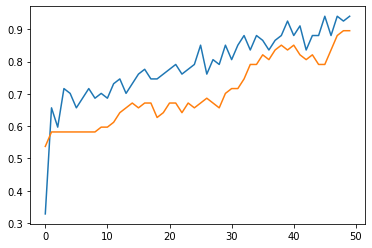

In [ ]:
train_net(a_net, a_optimizer, a_criterion, train_loader_a, val_loader_a, 50)

In [ ]:
eval_net(a_net, test_loader_a)

Test acc: 0.8060959578


  4%|▍         | 2/50 [00:00<00:04, 11.22it/s]

Train acc: 0.672, Val acc: 0.716
Train acc: 0.522, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 14%|█▍        | 7/50 [00:00<00:02, 19.08it/s]

Train acc: 0.731, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.701, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 26%|██▌       | 13/50 [00:00<00:01, 22.64it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 38%|███▊      | 19/50 [00:00<00:01, 24.81it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 50%|█████     | 25/50 [00:01<00:00, 25.47it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 62%|██████▏   | 31/50 [00:01<00:00, 25.76it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.701, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716


 74%|███████▍  | 37/50 [00:01<00:00, 25.79it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.701, Val acc: 0.731
Train acc: 0.731, Val acc: 0.716
Train acc: 0.701, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716
Train acc: 0.761, Val acc: 0.716


 86%|████████▌ | 43/50 [00:01<00:00, 25.93it/s]

Train acc: 0.731, Val acc: 0.716
Train acc: 0.716, Val acc: 0.701
Train acc: 0.701, Val acc: 0.701
Train acc: 0.731, Val acc: 0.701
Train acc: 0.761, Val acc: 0.701
Train acc: 0.746, Val acc: 0.731


 98%|█████████▊| 49/50 [00:02<00:00, 25.64it/s]

Train acc: 0.731, Val acc: 0.761
Train acc: 0.746, Val acc: 0.761
Train acc: 0.806, Val acc: 0.776
Train acc: 0.791, Val acc: 0.776
Train acc: 0.836, Val acc: 0.776


100%|██████████| 50/50 [00:02<00:00, 24.13it/s]

Train acc: 0.761, Val acc: 0.821


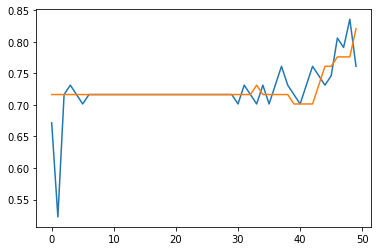

In [ ]:
train_net(d_net, d_optimizer, d_criterion, train_loader_d, val_loader_d, 50)

In [ ]:
eval_net(d_net, test_loader_d)

Test acc: 0.7522698045


## Saving Nets

In [ ]:
torch.save(v_net.state_dict(), cwd + '/vnet')

In [ ]:
torch.save(a_net.state_dict(), cwd + '/anet')

In [ ]:
torch.save(d_net.state_dict(), cwd + 'dnet')

In [ ]:
tester = CNN_LSTM()
tester.load_state_dict(torch.load(cwd + '/vnet'))

<All keys matched successfully>

## Emotions (for later)

In [ ]:
class CNN_LSTM2(nn.Module):
    def __init__(self):
        super(CNN_LSTM2, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [ ]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
emo_net = CNN_LSTM2()
print(emo_net.forward(Variable(input_tensor)))
e_criterion = nn.CrossEntropyLoss() # add to device here
e_optimizer = optim.Adam(emo_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.1739, 0.1834, 0.1254, 0.3558, 0.1200, 0.0415]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
formal_emotions = emo_labels['Emo']
formal_emotions = formal_emotions.to_numpy()

In [ ]:
formal_emotions = formal_emotions.reshape((formal_emotions.size, 1))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat = OneHotEncoder()
emotions_onehot = cat.fit_transform(formal_emotions).toarray()

In [ ]:
emotion_labels = []
for i in range(23):
    j = 0
    while (j < 211 and np.sum(eeg_s1[i,:,j,:])):
        emotion_labels.append(emotions_onehot[i])
        j += 1
print(len(emotion_labels))

NameError: name 'eeg_s1' is not defined

In [ ]:
emotion_labels = np.array(emotion_labels)

In [ ]:
y_train_e = emotion_labels[train_indices]
y_valid_e = emotion_labels[valid_indices]
y_test_e = emotion_labels[test_indices]

In [ ]:
train_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_e))
val_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_e))
test_dataset_e = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_e))

train_loader_e = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_e = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_e = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

  2%|▏         | 1/50 [00:01<01:33,  1.91s/it]

Train acc: 0.521, Val acc: 0.693


  4%|▍         | 2/50 [00:03<01:28,  1.84s/it]

Train acc: 0.754, Val acc: 0.823


  6%|▌         | 3/50 [00:05<01:22,  1.75s/it]

Train acc: 0.878, Val acc: 0.849


  8%|▊         | 4/50 [00:06<01:17,  1.69s/it]

Train acc: 0.946, Val acc: 0.903


 10%|█         | 5/50 [00:08<01:15,  1.68s/it]

Train acc: 0.984, Val acc: 0.981


 12%|█▏        | 6/50 [00:10<01:13,  1.66s/it]

Train acc: 0.999, Val acc: 0.973


 14%|█▍        | 7/50 [00:11<01:10,  1.64s/it]

Train acc: 0.999, Val acc: 0.994


 16%|█▌        | 8/50 [00:13<01:09,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 18%|█▊        | 9/50 [00:15<01:08,  1.67s/it]

Train acc: 1.000, Val acc: 0.996


 20%|██        | 10/50 [00:16<01:07,  1.68s/it]

Train acc: 1.000, Val acc: 0.981


 22%|██▏       | 11/50 [00:18<01:04,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 24%|██▍       | 12/50 [00:20<01:02,  1.65s/it]

Train acc: 1.000, Val acc: 1.000


 26%|██▌       | 13/50 [00:21<01:00,  1.62s/it]

Train acc: 1.000, Val acc: 0.994


 28%|██▊       | 14/50 [00:24<01:06,  1.84s/it]

Train acc: 1.000, Val acc: 1.000


 30%|███       | 15/50 [00:26<01:05,  1.88s/it]

Train acc: 1.000, Val acc: 1.000


 32%|███▏      | 16/50 [00:27<01:03,  1.87s/it]

Train acc: 1.000, Val acc: 0.997


 34%|███▍      | 17/50 [00:29<00:59,  1.80s/it]

Train acc: 1.000, Val acc: 1.000


 36%|███▌      | 18/50 [00:31<00:56,  1.76s/it]

Train acc: 1.000, Val acc: 1.000


 38%|███▊      | 19/50 [00:32<00:53,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 40%|████      | 20/50 [00:34<00:50,  1.69s/it]

Train acc: 1.000, Val acc: 0.997


 42%|████▏     | 21/50 [00:35<00:47,  1.64s/it]

Train acc: 1.000, Val acc: 0.993


 44%|████▍     | 22/50 [00:37<00:45,  1.63s/it]

Train acc: 1.000, Val acc: 0.981


 46%|████▌     | 23/50 [00:39<00:44,  1.64s/it]

Train acc: 1.000, Val acc: 0.988


 48%|████▊     | 24/50 [00:40<00:41,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 50%|█████     | 25/50 [00:42<00:39,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 52%|█████▏    | 26/50 [00:43<00:38,  1.59s/it]

Train acc: 1.000, Val acc: 0.997


 54%|█████▍    | 27/50 [00:45<00:37,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 56%|█████▌    | 28/50 [00:47<00:35,  1.61s/it]

Train acc: 1.000, Val acc: 0.997


 58%|█████▊    | 29/50 [00:48<00:34,  1.66s/it]

Train acc: 1.000, Val acc: 1.000


 60%|██████    | 30/50 [00:50<00:33,  1.68s/it]

Train acc: 1.000, Val acc: 0.997


 62%|██████▏   | 31/50 [00:53<00:38,  2.03s/it]

Train acc: 1.000, Val acc: 1.000


 64%|██████▍   | 32/50 [00:56<00:40,  2.23s/it]

Train acc: 1.000, Val acc: 0.997


 66%|██████▌   | 33/50 [00:57<00:35,  2.08s/it]

Train acc: 1.000, Val acc: 1.000


 68%|██████▊   | 34/50 [00:59<00:31,  1.95s/it]

Train acc: 1.000, Val acc: 1.000


 70%|███████   | 35/50 [01:01<00:27,  1.86s/it]

Train acc: 1.000, Val acc: 0.997


 72%|███████▏  | 36/50 [01:02<00:25,  1.82s/it]

Train acc: 1.000, Val acc: 1.000


 74%|███████▍  | 37/50 [01:04<00:22,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 76%|███████▌  | 38/50 [01:05<00:20,  1.68s/it]

Train acc: 1.000, Val acc: 0.988


 78%|███████▊  | 39/50 [01:07<00:18,  1.67s/it]

Train acc: 1.000, Val acc: 0.963


 80%|████████  | 40/50 [01:09<00:16,  1.66s/it]

Train acc: 0.991, Val acc: 0.917


 82%|████████▏ | 41/50 [01:10<00:14,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 84%|████████▍ | 42/50 [01:12<00:12,  1.62s/it]

Train acc: 0.996, Val acc: 1.000


 86%|████████▌ | 43/50 [01:14<00:11,  1.69s/it]

Train acc: 1.000, Val acc: 0.975


 88%|████████▊ | 44/50 [01:16<00:10,  1.70s/it]

Train acc: 0.999, Val acc: 0.991


 90%|█████████ | 45/50 [01:17<00:08,  1.68s/it]

Train acc: 0.996, Val acc: 0.960


 92%|█████████▏| 46/50 [01:19<00:06,  1.61s/it]

Train acc: 0.988, Val acc: 0.963


 94%|█████████▍| 47/50 [01:20<00:05,  1.69s/it]

Train acc: 0.999, Val acc: 1.000


 96%|█████████▌| 48/50 [01:22<00:03,  1.70s/it]

Train acc: 1.000, Val acc: 0.987


 98%|█████████▊| 49/50 [01:24<00:01,  1.87s/it]

Train acc: 0.999, Val acc: 0.985


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]

Train acc: 0.997, Val acc: 1.000


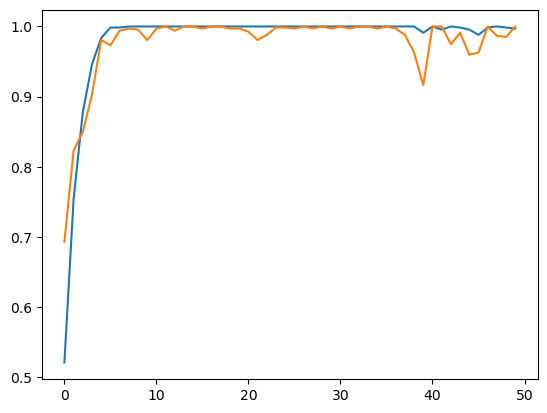

In [ ]:
train_net(emo_net, e_optimizer, e_criterion, train_loader_e, val_loader_e, 50)

In [ ]:
eval_net(emo_net, test_loader_e)

Test acc: 1.0000000000
